In [5]:
from math import sin,cos,pi,log,exp
import matplotlib.pyplot as plt
import numpy as np
import cfeplib

In [6]:
f=open('oxtrajtraj-2-0.rmsd')
lrmsd=[]
for l in f:
    l=l.split()
    lrmsd.append(float(l[1]))
f.close()

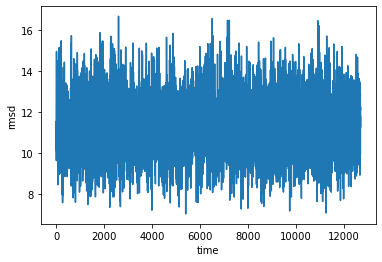

In [7]:
plt.plot(lrmsd[0:-1:100])
plt.xlabel('time')
_=plt.ylabel('rmsd')

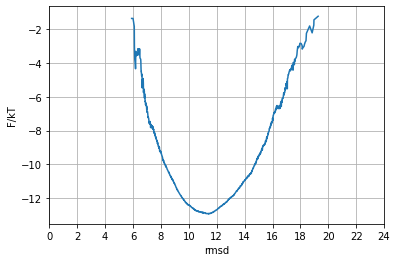

In [8]:
lx,lzh=cfeplib.comp_Zca(lrmsd,a=-1,dx=0.01,dt=1,strict=False)
lf=[-log(zh*2) for zh in lzh]

plt.plot(lx,lf)
plt.xticks(np.arange(0, 25, step=2))
plt.grid()
plt.xlabel('rmsd')
_=plt.ylabel('F/kT')


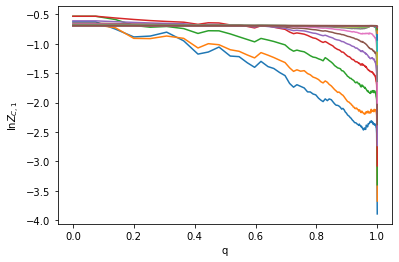

In [9]:
lq=cfeplib.to_committor(lrmsd,0.01,6,11)

ldt=[2**i for i in range(16)]
dx=0.001
for dt in ldt:
    ekn=cfeplib.comp_ekn_tp(lq,x0=0,x1=1,dx=dx,dt=dt)
    lx,lzc1=cfeplib.comp_Zca_ekn(ekn,a=1)
    plt.plot(lx,-np.log(lzc1))
plt.xlabel('q')
_=plt.ylabel('$\ln Z_{C,1}$')

In [10]:
def Nab_traj(lrmsd,a,b):
    il=None
    n=0
    for x in lrmsd:
        ic=None
        if x<a: ic=1
        if x>b: ic=2
        if ic!=None and il!=None and ic!=il: n+=1
        if ic!=None: il=ic
    return n/2.
        
def Nab_model(lx,lzc1,a,b):
    lx1=[lx[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    ly1=[1/lzc1[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    
    from scipy.integrate import simps
    I=simps(ly1,lx1)
    return 1./I

a=6
b=11
lx1,ly1=cfeplib.comp_Zca(lrmsd,a=1,dx=0.0001)
print (Nab_traj(lrmsd,a,b),Nab_model(lx1,ly1,a,b))

1.0 3.210975217303019


In [11]:
for dt in range(1,11):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

1 1.0 3.210975217303019
2 0.0 4.0971122299889915
3 1.0 2.857576695859898
4 0.0 0.9967054492221327
5 0.0 1.209081424127977
6 0.0 3.066296293940516
7 0.0 2.908946727535532
8 0.0 4.395402508238662
9 0.0 2.6571249974484754
10 0.0 3.214226778181586


In [12]:
for dt in range(10,40):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

10 0.0 3.214226778181586
11 0.0 2.751243837750373
12 0.0 4.62642188806017
13 0.0 4.231651474054011
14 0.0 3.8430610368662275
15 0.0 19.628850139780024
16 0.0 4.3874903887879215
17 0.0 6.001778713372488
18 0.0 8.654175197990773
19 0.0 3.145203250134368
20 0.0 5.18368216482169
21 0.0 2.236677246110536
22 0.0 7.291904404425168
23 0.0 6.847872747951119
24 0.0 4.480727908224125
25 0.0 12.83216770965855
26 0.0 2.8504826401097945
27 0.0 2.7221070366371176
28 0.0 2.342752513823729
29 0.0 9.18924090924899
30 0.0 14.143707601203957
31 0.0 12.591512462894952
32 0.0 12.962292259197794
33 0.0 7.78226760154965
34 0.0 6.151873637405455
35 0.0 3.6792699167687775
36 0.0 6.370206890711796
37 0.0 19.292573821926826
38 0.0 3.2177555255941876
39 0.0 11.520564033813418


In [13]:
def fab_model(lrmsd,a,b,dx=0.001):
    lx,lzc1=cfeplib.comp_Zca(lrmsd,1,dx=dx)
    lx,lzh=cfeplib.comp_Zca(lrmsd,-1,dx=dx)
    from scipy.integrate import cumtrapz,simps
    ly=[1/y for y in lzc1]
    lq=cumtrapz(ly,lx,initial=0)
    lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
    lqa.sort()
    ia=lqa[0][-1]
    qa=lq[ia]
    lqb=[(abs(x-b),i) for i,x in enumerate(lx)]
    lqb.sort()
    ib=lqb[0][-1]
    qb=lq[ib]
    def qp(q,qa,qb):
        if q<qa: return 0
        if q>qb: return 1
        return (q-qa)/(qb-qa)
    lqp=[qp(q,qa,qb) for q in lq]
    lind=[1 if a<x and x<b else 0 for x in lx]
    nab=1/simps([ind/zc1 for ind,zc1 in zip(lind,lzc1)],lx)
    n=len(lrmsd)
    ztot=simps(lzh,lx)
    mfptab=simps([zh*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mfptba=simps([zh*q for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mtpt=simps([zh*q*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    return nab,mfptab,mfptba,mtpt

def fab_traj(lrmsd,a,b):
    il=None
    nab=0
    mfptab=0
    mfptba=0
    mtpt=0
    tp=0
    fp=0
    for i,x in enumerate(lrmsd):
        if x<a: 
            ic=1
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptba=mfptba+i-fp
                fp=i
            il=ic
            tp=i
        if x>b: 
            ic=2
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptab=mfptab+i-fp
                fp=i
            il=ic
            tp=i
    return nab/2.,2.*mfptab/nab,2.*mfptba/nab,float(mtpt)/nab
     
print('model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(lrmsd,a,b))    
print('traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(lrmsd,a,b))

model: NAB=2.40094, mfpt_AB=50.1021, mftp_BA=528135, mtpt=49.0001
traj:  NAB=1, mfpt_AB=192, mftp_BA=1.12484e+06, mtpt=109
